In [90]:
import torch.nn as nn
import torch
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from apex import amp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import glob
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from torch.utils.tensorboard import SummaryWriter
import time
from sklearn.preprocessing import OneHotEncoder

In [91]:
import dgl
from dgl.nn.pytorch import GraphConv
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import networkx as nx
from dgl import function as fn

In [92]:
# TODO Atom/AA feature reps -> maybe just embedding of the vocab!!
# next try atom/AA descriptor feature reps (but this would be a heterogeneous graph which might be tough)

In [93]:
# Start with basic built in GraphConv layers 
# Define an adjacency matrix using some cutoff threshold
# The node features are one hot encoded for protein/ligand

In [94]:
class GraphDistConv(GraphConv):
    def __init__(self,
                 in_feats,
                 out_feats,
                 norm='both',
                 weight=True,
                 bias=True,
                 activation=None):
        super(GraphDistConv, self).__init__(in_feats,out_feats,norm,weight,bias,activation)
        
    def forward(self, graph, feat, dist, weight=None):
        graph = graph.local_var()

        if self._norm == 'both':
            degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = torch.reshape(norm, shp)
            feat = feat * norm

        if weight is not None:
            if self.weight is not None:
                raise DGLError('External weight is provided while at the same time the'
                               ' module has defined its own weight parameter. Please'
                               ' create the module with flag weight=False.')
        else:
            weight = self.weight

        if self._in_feats > self._out_feats:
            # mult W first to reduce the feature size for aggregation.
            if weight is not None:
                feat = torch.matmul(feat, weight)
            graph.srcdata['h'] = feat
            graph.edata['w'] = dist
            graph.update_all(fn.u_mul_e('h', 'w', out='m'), fn.sum('m', 'h'))
#             graph.update_all(fn.copy_src(src='h', out='m'),
#                              fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
        else:
            # aggregate first then mult W
            graph.srcdata['h'] = feat
            graph.edata['w'] = dist
            graph.update_all(fn.u_mul_e('h', 'w', out='m'), fn.sum('m', 'h'))
#             graph.update_all(fn.copy_src(src='h', out='m'),
#                              fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']

            if weight is not None:
                rst = torch.matmul(rst, weight)

        if self._norm != 'none':
            degs = graph.in_degrees().to(feat.device).float().clamp(min=1)
            if self._norm == 'both':
                norm = torch.pow(degs, -0.5)
            else:
                norm = 1.0 / degs
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = torch.reshape(norm, shp)
            rst = rst * norm

        if self.bias is not None:
            rst = rst + self.bias

        if self._activation is not None:
            rst = self._activation(rst)

        return rst

In [95]:
class GCN(nn.Module):
    def __init__(self, g, in_feats, h1, h2):
        super(GCN, self).__init__()
        self.g = g
        self.conv1 = GraphDistConv(in_feats, h1)
        self.conv2 = GraphDistConv(h1, h2)
        self.linear = nn.Linear(h2,1)

    def forward(self, inputs, dist):
        h = self.conv1(self.g, inputs, dist)
        h = torch.relu(h)
        h = self.conv2(self.g, h, dist)
        h = torch.relu(h)
        fp = torch.sum(h, dim=0)
        out = self.linear(fp)
        return out

In [96]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graph):
        'Initialization'
        self.graph = graph

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.graph)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.graph[index]

In [102]:
atom_residues = [
            "ALA",
            "ARG",
            "ASN",
            "ASP",
            "CYS",
            "GLN",
            "GLU",
            "GLY",
            "HIS",
            "ILE",
            "LEU",
            "LYS",
            "MET",
            "PHE",
            "PRO",
            "SER",
            "THR",
            "TRP",
            "TYR",
            "VAL",
           "H", 
           "I",
           "N",
           "P",
           "C",
           "O",
           "F",
           "S",
           "Li",
           "Cl",
           "Br"]

encoder = OneHotEncoder(sparse=False).fit(np.array(atom_residues).reshape(-1,1))
embedding = nn.Embedding(num_embeddings=len(atom_residues), embedding_dim=20)

In [98]:
# graph dataset is the same as image except no interpolation and only one "channel"
graphs,docks = pickle.load(open("dset_jak2_8a_80x80_NEAREST_graph.pkl", "rb"))

In [110]:
protein = '#00FFFF'
ligand = '#FF00FF' 
def cutoff(val):
    return 1 if val < 0.5 else 0 #only within 8 angstrom considered connection

def build_graph(graph,feat, dock):
    # read matrix, cutoff at 3 angstroms to create adjacency matrix
    adj_matrix = np.array([[cutoff(y) for y in x] for x in graph])

    # use networkx to create a graph from adjacency matrix
    # visualize
    vis = nx.from_numpy_matrix(adj_matrix)
    # Kamada-Kawaii layout usually looks pretty for arbitrary graphs
    #pos = nx.kamada_kawai_layout(vis)
    #nx.draw(vis, pos, with_labels=True, node_color=[ligand if i[0] == 1 else protein for i in feat])
    
    
    # convert to DGL graph
    g = dgl.DGLGraph()
    g = dgl.from_networkx(vis)
    edges = graph*adj_matrix
    for i in range(edges.shape[0]):
        edges[i][i] = 1
    edges=edges[edges!=0]
    edges = 1/edges
    edges[edges==1]=0
    
#     # create node features
    feat = encoder.transform(np.array(feat).reshape(-1,1))
    #indices = [atom_residues.index(i) for i in feat]
    #feat = embedding.weight[indices]
    print(feat.shape)
    g.ndata['feat'] = torch.FloatTensor(feat)
   # g.ndata['feat'] = torch.nn.Embedding(adj_matrix.shape[0], 32).weight
    g.ndata['label'] = torch.FloatTensor(dock*np.ones(adj_matrix.shape[0]))
    g.edata['inv_dist'] = torch.FloatTensor(edges)

    return g

In [111]:
data = []
y = np.abs(docks)
for i in range(10000):
    data.append(build_graph(graphs[i][0],graphs[i][2], y[i]))


(75, 31)
(81, 31)
(78, 31)
(79, 31)
(77, 31)
(72, 31)
(76, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(77, 31)
(72, 31)
(74, 31)
(74, 31)
(79, 31)
(77, 31)
(75, 31)
(75, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(80, 31)
(80, 31)
(79, 31)
(76, 31)
(79, 31)
(78, 31)
(78, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(81, 31)
(81, 31)
(80, 31)
(78, 31)
(77, 31)
(76, 31)
(78, 31)
(80, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(76, 31)
(75, 31)
(80, 31)
(80, 31)
(83, 31)
(70, 31)
(77, 31)
(83, 31)
(73, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(81, 31)
(76, 31)
(75, 31)
(77, 31)
(75, 31)
(75, 31)
(80, 31)
(81, 31)
(86, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(81, 31)
(78, 31)
(80, 31)
(80, 31)
(76, 31)
(81, 31)
(77, 31)
(78, 31)
(80, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(75, 31)
(72, 31)
(79, 31)
(78, 31)
(77, 31)
(78, 31)
(79, 31)
(80, 31)
(78, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(81, 31)
(76, 31)
(78, 31)
(79, 31)
(79, 31)
(79, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashk

(82, 31)
(81, 31)
(81, 31)
(83, 31)
(77, 31)
(80, 31)


/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


KeyboardInterrupt: 

In [107]:
print(len(data))
pickle.dump((data),open("graphs_10k_emb.pkl","wb"),protocol=4)

10000


In [82]:
data_sub=data[0:1000]
x_train, x_val, _, _ = train_test_split(data_sub,data_sub,test_size=0.2, shuffle=True)
train_dataset = GraphDataset(x_train)
test_dataset = GraphDataset(x_val)

In [83]:
from torch.utils.data import DataLoader
# function to concatenate/batch graphs
# creates one large graph per batch that has disjoint subgraphs
def collate(data):
    graph = dgl.batch(data)
    return graph

In [84]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [85]:
batch_size=1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)
g = train_dataset[0]
n_classes = 1
num_feats = g.ndata['feat'].shape[1]
g = g.int().to(device)
# define the model
model = GCN(g,
            num_feats,
            64,
            64)
# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
lr_red = ReduceLROnPlateau(optimizer, patience=10, threshold=0.01)
model = model.to(device)
loss_fcn = nn.MSELoss()
num_epochs=50
loss_train_store=[]
loss_test_store=[]

r2_train_store=[]
r2_test_store=[]
for epoch in range(num_epochs):
    model.train()
    loss_acc=0
    iters=0
    y_pred_values=[]
    y_test_values=[]
    for batch, subgraph in enumerate(train_dataloader):
        subgraph = subgraph.to(device)

        model.g = subgraph
        y_pred = model(subgraph.ndata['feat'].float(), subgraph.edata['inv_dist'].float())
        loss = loss_fcn(y_pred[0], subgraph.ndata['label'].float()[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_acc+=loss.item()
        iters+=1
        y_pred_values.append(y_pred.cpu()[0])
        y_test_values.append(subgraph.ndata['label'].float().cpu()[0])  
    r2_train = r2_score( y_test_values, y_pred_values)  
    r2_train_store.append(r2_train)

            
    loss_train_store.append(loss_acc/iters)
    lr_red.step(loss_train_store[-1])
    with torch.no_grad():
        model.eval()
        loss_acc=0
        iters=0
        y_pred_values=[]
        y_test_values=[]
        for batch, subgraph in enumerate(test_dataloader):
            subgraph = subgraph.to(device)
            model.g = subgraph
            y_pred = model(subgraph.ndata['feat'].float(), subgraph.edata['inv_dist'].float())
            loss = loss_fcn(y_pred[0],subgraph.ndata['label'].float()[0])        

            loss_acc+=loss.item()
            iters+=1

            y_pred_values.append(y_pred.cpu()[0])
            y_test_values.append(subgraph.ndata['label'].float().cpu()[0])  

        r2_test = r2_score( y_test_values, y_pred_values)    
        loss_test_store.append(loss_acc/iters)
        r2_test_store.append(r2_test)

    print(epoch, loss_train_store[-1], loss_test_store[-1], r2_train_store[-1], r2_test_store[-1])


DGLError: [13:46:49] /opt/dgl/src/array/cuda/utils.cu:21: Check failed: e == cudaSuccess || e == cudaErrorCudartUnloading: CUDA: out of memory
Stack trace:
  [bt] (0) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x7fb25bee9a7f]
  [bt] (1) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::cuda::AllTrue(signed char*, long, DLContext const&)+0x1f0) [0x7fb25cc01cc3]
  [bt] (2) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(std::pair<bool, bool> dgl::aten::impl::COOIsSorted<(DLDeviceType)2, long>(dgl::aten::COOMatrix)+0x1aa) [0x7fb25c72d7b4]
  [bt] (3) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::aten::COOIsSorted(dgl::aten::COOMatrix)+0x1e3) [0x7fb25bece5d3]
  [bt] (4) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::aten::CSRMatrix dgl::aten::impl::COOToCSR<(DLDeviceType)2, long>(dgl::aten::COOMatrix)+0xb4) [0x7fb25c72b0ef]
  [bt] (5) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::aten::COOToCSR(dgl::aten::COOMatrix)+0x3f3) [0x7fb25becd293]
  [bt] (6) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::UnitGraph::GetOutCSR(bool) const+0x2ee) [0x7fb25c6b2f1e]
  [bt] (7) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::UnitGraph::GetFormat(dgl::SparseFormat) const+0x7d) [0x7fb25c6b378d]
  [bt] (8) /vol/ml/shahashka/anaconda3/envs/ml-fragment/lib/python3.7/site-packages/dgl/libdgl.so(dgl::UnitGraph::OutDegrees(unsigned long, dgl::runtime::NDArray) const+0x32) [0x7fb25c6b4e62]



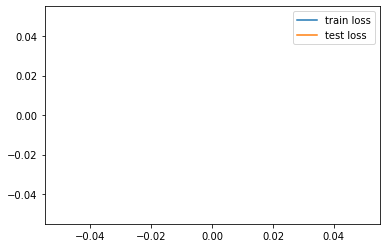

In [86]:
plt.plot(loss_train_store, label='train loss')
plt.plot(loss_test_store, label='test loss')
plt.legend()

In [ ]:
plt.plot(r2_train_store, label='train loss')
plt.plot(r2_test_store, label='test loss')
plt.legend()

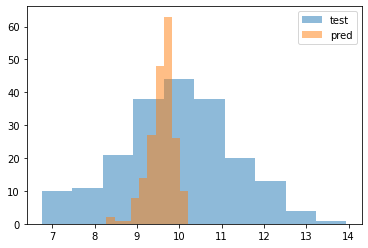

In [28]:
plt.hist(y_test_values, label="test", alpha=0.5)
plt.hist(y_pred_values, label="pred", alpha=0.5)
plt.legend()

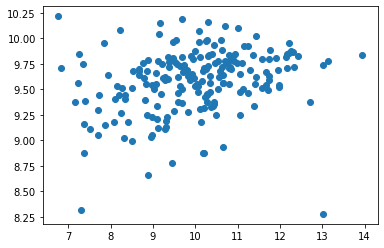

In [29]:
plt.scatter(np.array(y_test_values), np.array(y_pred_values))

In [30]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from regression_enrichment_surface import regression_enrichment_surface as rds
rds_model = rds.RegressionEnrichmentSurface(percent_min=-3)
rds_model.compute(np.array(y_test_values).flatten(), np.array(y_pred_values).flatten(), samples=30)
rds_model.plot(save_file="rds_on_cell.png",
                   title='Regression Enrichment Surface (Avg over Unique Cells)')

ZeroDivisionError: division by zero